Modified from https://github.com/eugeniaring/Pytorch-tutorial/blob/main/denAE.ipynb

In [1]:
import numpy as np
import random
import os
from tqdm import tqdm

import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim

# Download MNIST and show some samples

In [2]:
data_dir = 'data'

train_dataset = MNIST(
    data_dir, train=True, download=True,
    transform=transforms.ToTensor(),
)

val_dataset = MNIST(
    data_dir, train=False, download=True,
    transform=transforms.ToTensor(),
)

In [3]:
# Split data in train and validation

split_idx = int(len(train_dataset) * 0.8)

batch_size = 512

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

## Define the autoencoder

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, img_size, code_size):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(3*3*32, code_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(code_size, 3*3*32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

        self.img_size = img_size
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.reshape(-1, 1, self.img_size, self.img_size)

## Initialize model, loss and optimizer

In [5]:
img_size = 28
code_size = 8

model = AutoEncoder(img_size, code_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [6]:
loss_fn = torch.nn.MSELoss()

lr = 0.001

params_to_optimize = [
    {'params': model.parameters()},
]

optimizer = torch.optim.Adam(params_to_optimize, lr=lr)

## Train model

In [7]:
def add_noise(inputs, noise_factor=0.3):
    noise = inputs + noise_factor * torch.randn_like(inputs)
    noise = torch.clip(noise, 0., 1.)
    return noise

In [8]:
train_losses = []
val_losses = []

In [9]:
num_epochs = 10
noise_factor = 0.3

for epoch in range(num_epochs):
    model.train()
    
    for image_batch, _ in tqdm(train_loader):
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)

        decoded_data = model(image_noisy)

        loss = loss_fn(decoded_data, image_noisy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().cpu().numpy())



    model.eval()
    epoch_val_losses = []
    for image_batch, _ in tqdm(val_loader):
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)

        with torch.no_grad():
            decoded_data = model(image_noisy)

        val_loss = loss_fn(decoded_data, image_noisy)
        epoch_val_losses.append(val_loss.cpu().numpy())

    val_losses.append(np.mean(epoch_val_losses))

100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


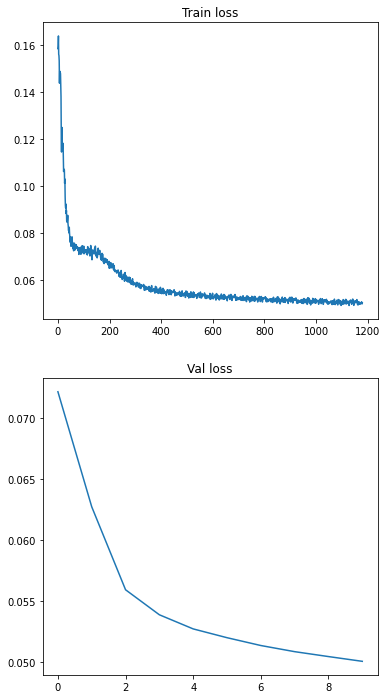

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, figsize=(6, 12))

axes[0].set_title('Train loss')
axes[0].plot(train_losses)

axes[1].set_title('Val loss')
axes[1].plot(val_losses)

## Small test

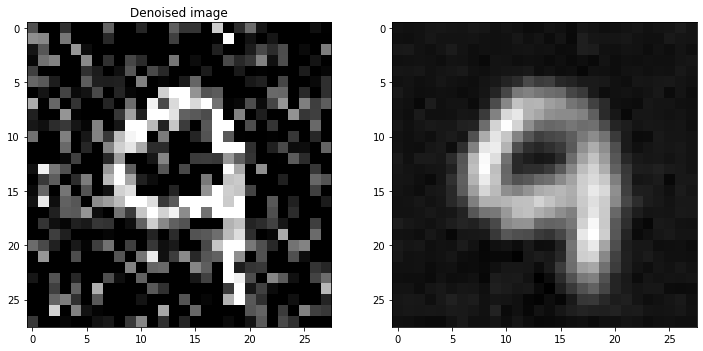

In [27]:
import matplotlib.pyplot as plt
from random import sample


fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

val_img, _ = sample(list(val_dataset), 1)[0]

noisy_val_img = add_noise(val_img)

model.eval()

with torch.no_grad():
    output = model(noisy_val_img.to(device)[None, ...])[0, ...]

denoised_val_img = output.clip(0, 1).cpu().numpy()

axes[0].set_title('Noisy image')
axes[0].imshow(noisy_val_img[0], cmap='gray')

axes[0].set_title('Denoised image')
axes[1].imshow(denoised_val_img[0], cmap='gray')